In [1]:
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def generate_knapsack_instance(n_items, capacity_factor=0.5, min_weight=1, max_weight=100, min_value=1, max_value=100, seed=None):
    """
    Generate a random knapsack instance.
    Parameters:
    -----------
    n_items : int
        Number of items
    capacity_factor : float
        Capacity as a fraction of sum of all weights
    min_weight, max_weight : int
        Min and max item weights
    min_value, max_value : int
        Min and max item values
    seed : int or None
        Random seed     
    Returns:
    --------
    dict
        Dictionary with weights, values, and capacity
    """
    if seed is not None:
        np.random.seed(seed)
        
    weights = np.random.randint(min_weight, max_weight + 1, size=n_items)
    values = np.random.randint(min_value, max_value + 1, size=n_items)
    
    # Set capacity as a fraction of total weight
    capacity = int(np.sum(weights) * capacity_factor)
    
    return {
        'weights': weights,
        'values': values,
        'capacity': capacity
    }

In [3]:
def solve_knapsack_dp(weights, values, capacity):
    """
    Solve the 0-1 knapsack problem using dynamic programming.
    
    Parameters:
    -----------
    weights : array
        Item weights
    values : array
        Item values
    capacity : int
        Knapsack capacity
        
    Returns:
    --------
    tuple
        (max_value, selected_items)
    """
    n = len(weights)
    
    # Initialize DP table
    dp = [[0 for _ in range(capacity + 1)] for _ in range(n + 1)]
    
    # Fill DP table
    for i in range(1, n + 1):
        for w in range(capacity + 1):
            if weights[i-1] <= w:
                dp[i][w] = max(values[i-1] + dp[i-1][w-weights[i-1]], dp[i-1][w])
            else:
                dp[i][w] = dp[i-1][w]
    
    # Reconstruct solution
    selected = [0] * n
    w = capacity
    for i in range(n, 0, -1):
        if dp[i][w] != dp[i-1][w]:
            selected[i-1] = 1
            w -= weights[i-1]
    
    return dp[n][capacity], selected

In [4]:
def solve_knapsack_ga(weights, values, capacity, population_size=100, num_generations=200, mutation_rate=0.01):
    """
    Solve the 0-1 knapsack problem using a genetic algorithm.
    
    Parameters:
    -----------
    weights : array
        Item weights
    values : array
        Item values
    capacity : int
        Knapsack capacity
    population_size : int
        Size of the population
    num_generations : int
        Number of generations
    mutation_rate : float
        Probability of mutation
        
    Returns:
    --------
    tuple
        (max_value, selected_items)
    """
    n = len(weights)
    
    # Helper function to calculate fitness
    def calculate_fitness(solution):
        total_weight = sum(weights[i] for i in range(n) if solution[i] == 1)
        if total_weight > capacity:
            return 0  # Infeasible solution
        return sum(values[i] for i in range(n) if solution[i] == 1)
    
    # Initialize population
    population = []
    for _ in range(population_size):
        # Random binary string
        individual = [np.random.randint(0, 2) for _ in range(n)]
        population.append(individual)
    
    best_fitness = 0
    best_solution = None
    
    # Evolution
    for _ in range(num_generations):
        # Calculate fitness for each individual
        fitness_scores = [calculate_fitness(individual) for individual in population]
        
        # Keep track of best solution
        current_best_idx = np.argmax(fitness_scores)
        if fitness_scores[current_best_idx] > best_fitness:
            best_fitness = fitness_scores[current_best_idx]
            best_solution = population[current_best_idx].copy()
        
        # Selection: tournament selection
        new_population = []
        for _ in range(population_size):
            # Tournament selection
            tournament_size = 5
            tournament_indices = np.random.choice(population_size, tournament_size, replace=False)
            tournament_fitness = [fitness_scores[i] for i in tournament_indices]
            winner_idx = tournament_indices[np.argmax(tournament_fitness)]
            new_population.append(population[winner_idx].copy())
        
        # Crossover: single-point crossover
        for i in range(0, population_size, 2):
            if i + 1 < population_size:  # Ensure we have a pair
                crossover_point = np.random.randint(1, n)
                temp = new_population[i][crossover_point:]
                new_population[i][crossover_point:] = new_population[i + 1][crossover_point:]
                new_population[i + 1][crossover_point:] = temp
        
        # Mutation
        for i in range(population_size):
            for j in range(n):
                if np.random.random() < mutation_rate:
                    new_population[i][j] = 1 - new_population[i][j]
        
        population = new_population
    
    # Return best solution found
    if best_solution is None:
        return 0, [0] * n
    
    return best_fitness, best_solution

In [5]:
def run_comparative_experiment(item_sizes, capacities, repeats=3, 
                              ga_params={'population_size': 100, 'num_generations': 200, 'mutation_rate': 0.01},
                              output_file='results/comparison_results.csv'):
    """
    Run a comprehensive experiment comparing DP and GA approaches.
    
    Parameters:
    -----------
    item_sizes : list
        List of item counts to test
    capacities : list
        List of capacity factors to test (0.0-1.0)
    repeats : int
        Number of repeats for each configuration
    ga_params : dict
        GA parameters
    output_file : str
        Output CSV file path
    
    Returns:
    --------
    pd.DataFrame
        Results dataframe
    """
    # Ensure output directory exists
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    
    results = []
    
    total_experiments = len(item_sizes) * len(capacities) * repeats
    
    with tqdm(total=total_experiments, desc="Running comparative experiments") as pbar:
        for n_items in item_sizes:
            for capacity_factor in capacities:
                for repeat in range(repeats):
                    # Generate instance
                    instance = generate_knapsack_instance(n_items, capacity_factor=capacity_factor)
                    weights = instance['weights']
                    values = instance['values']
                    capacity = instance['capacity']
                    
                    # Empty result dictionary
                    result = {
                        'n_items': n_items,
                        'capacity': capacity,
                        'capacity_factor': capacity_factor,
                        'repeat': repeat,
                        'dp_runtime': None,
                        'dp_value': None,
                        'ga_runtime': None,
                        'ga_value': None
                    }
                    
                    # Add GA parameters to result
                    result.update(ga_params)
                    
                    # Skip DP for very large instances (memory error prevention)
                    skip_dp = n_items * capacity > 10000000  # Adjust threshold as needed
                    
                    # Run DP
                    if not skip_dp:
                        start_time = time.time()
                        dp_value, dp_selected = solve_knapsack_dp(weights, values, capacity)
                        dp_runtime = time.time() - start_time
                        
                        result['dp_runtime'] = dp_runtime
                        result['dp_value'] = dp_value
                    
                    # Run GA
                    start_time = time.time()
                    ga_value, ga_selected = solve_knapsack_ga(
                        weights, values, capacity,
                        population_size=ga_params['population_size'],
                        num_generations=ga_params['num_generations'],
                        mutation_rate=ga_params['mutation_rate']
                    )
                    ga_runtime = time.time() - start_time
                    
                    result['ga_runtime'] = ga_runtime
                    result['ga_value'] = ga_value
                    
                    results.append(result)
                    pbar.update(1)
                    
                    # Checkpoint: save intermediate results
                    if len(results) % 10 == 0:
                        pd.DataFrame(results).to_csv(output_file, index=False)
    
    # Save final results
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_file, index=False)
    print(f"Comparative results saved to {output_file}")
    
    return results_df

In [6]:
# Cell 6: Run parameter sensitivity experiment
def run_parameter_sensitivity_experiment(n_items=100, capacity_factor=0.5, repeats=3,
                                         population_sizes=[50, 100, 200, 500],
                                         mutation_rates=[0.001, 0.01, 0.05, 0.1],
                                         generation_counts=[50, 100, 200, 500],
                                         output_file='results/parameter_sensitivity.csv'):
    """
    Run experiments to analyze GA parameter sensitivity.
    
    Parameters:
    -----------
    n_items : int
        Number of items for the test
    capacity_factor : float
        Capacity factor for test instances
    repeats : int
        Number of repeats
    population_sizes : list
        List of population sizes to test
    mutation_rates : list
        List of mutation rates to test
    generation_counts : list
        List of generation counts to test
    output_file : str
        Output CSV file path
    
    Returns:
    --------
    pd.DataFrame
        Results dataframe
    """
    # Ensure output directory exists
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    
    results = []
    
    # Calculate total number of experiments
    total_experiments = (len(population_sizes) + len(mutation_rates) + len(generation_counts)) * repeats
    
    with tqdm(total=total_experiments, desc="Running parameter sensitivity tests") as pbar:
        # Test population sizes
        for pop_size in population_sizes:
            for repeat in range(repeats):
                instance = generate_knapsack_instance(n_items, capacity_factor=capacity_factor)
                weights, values, capacity = instance['weights'], instance['values'], instance['capacity']
                
                # Run DP for reference (only once per instance)
                if repeat == 0:
                    start_time = time.time()
                    dp_value, _ = solve_knapsack_dp(weights, values, capacity)
                    dp_runtime = time.time() - start_time
                
                # Run GA with current population size
                start_time = time.time()
                ga_value, _ = solve_knapsack_ga(
                    weights, values, capacity,
                    population_size=pop_size,
                    num_generations=200,  # Default
                    mutation_rate=0.01    # Default
                )
                ga_runtime = time.time() - start_time
                
                results.append({
                    'parameter_type': 'population_size',
                    'parameter_value': pop_size,
                    'n_items': n_items,
                    'capacity': capacity,
                    'capacity_factor': capacity_factor,
                    'repeat': repeat,
                    'dp_value': dp_value if repeat == 0 else None,
                    'dp_runtime': dp_runtime if repeat == 0 else None,
                    'ga_value': ga_value,
                    'ga_runtime': ga_runtime,
                    'solution_quality': ga_value / dp_value if dp_value > 0 else 0
                })
                
                pbar.update(1)
                
        # Test mutation rates
        for mut_rate in mutation_rates:
            for repeat in range(repeats):
                instance = generate_knapsack_instance(n_items, capacity_factor=capacity_factor)
                weights, values, capacity = instance['weights'], instance['values'], instance['capacity']
                
                # Run DP for reference (only once per instance)
                if repeat == 0:
                    start_time = time.time()
                    dp_value, _ = solve_knapsack_dp(weights, values, capacity)
                    dp_runtime = time.time() - start_time
                
                # Run GA with current mutation rate
                start_time = time.time()
                ga_value, _ = solve_knapsack_ga(
                    weights, values, capacity,
                    population_size=100,  # Default
                    num_generations=200,  # Default
                    mutation_rate=mut_rate
                )
                ga_runtime = time.time() - start_time
                
                results.append({
                    'parameter_type': 'mutation_rate',
                    'parameter_value': mut_rate,
                    'n_items': n_items,
                    'capacity': capacity,
                    'capacity_factor': capacity_factor,
                    'repeat': repeat,
                    'dp_value': dp_value if repeat == 0 else None,
                    'dp_runtime': dp_runtime if repeat == 0 else None,
                    'ga_value': ga_value,
                    'ga_runtime': ga_runtime,
                    'solution_quality': ga_value / dp_value if dp_value > 0 else 0
                })
                
                pbar.update(1)
                
        # Test generation counts
        for num_gen in generation_counts:
            for repeat in range(repeats):
                instance = generate_knapsack_instance(n_items, capacity_factor=capacity_factor)
                weights, values, capacity = instance['weights'], instance['values'], instance['capacity']
                
                # Run DP for reference (only once per instance)
                if repeat == 0:
                    start_time = time.time()
                    dp_value, _ = solve_knapsack_dp(weights, values, capacity)
                    dp_runtime = time.time() - start_time
                
                # Run GA with current generation count
                start_time = time.time()
                ga_value, _ = solve_knapsack_ga(
                    weights, values, capacity,
                    population_size=100,  # Default
                    num_generations=num_gen,
                    mutation_rate=0.01    # Default
                )
                ga_runtime = time.time() - start_time
                
                results.append({
                    'parameter_type': 'num_generations',
                    'parameter_value': num_gen,
                    'n_items': n_items,
                    'capacity': capacity,
                    'capacity_factor': capacity_factor,
                    'repeat': repeat,
                    'dp_value': dp_value if repeat == 0 else None,
                    'dp_runtime': dp_runtime if repeat == 0 else None,
                    'ga_value': ga_value,
                    'ga_runtime': ga_runtime,
                    'solution_quality': ga_value / dp_value if dp_value > 0 else 0
                })
                
                pbar.update(1)
        
        # Checkpoint: save intermediate results
        if len(results) % 5 == 0:
            pd.DataFrame(results).to_csv(output_file, index=False)
    
    # Save final results
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_file, index=False)
    print(f"Parameter sensitivity results saved to {output_file}")
    
    return results_df


In [7]:
# Cell 7: Main function to run experiments
def main():
    """Main function to run all experiments"""
    print("Running Knapsack Algorithm Comparison Experiments")
    
    # Experiment 1: Comparative experiment
    print("\n=== Running Comparative Experiment ===")
    item_sizes = [50, 100, 200, 500, 1000]
    capacities = [0.25, 0.5, 0.75]
    comp_results = run_comparative_experiment(
        item_sizes=item_sizes,
        capacities=capacities,
        repeats=3,
        ga_params={'population_size': 100, 'num_generations': 200, 'mutation_rate': 0.01},
        output_file='results/comparison_results.csv'
    )
    
    # Experiment 2: Parameter sensitivity
    print("\n=== Running Parameter Sensitivity Experiment ===")
    param_results = run_parameter_sensitivity_experiment(
        n_items=100,
        capacity_factor=0.5,
        repeats=3,
        population_sizes=[50, 100, 200, 500],
        mutation_rates=[0.001, 0.01, 0.05, 0.1],
        generation_counts=[50, 100, 200, 500],
        output_file='results/parameter_sensitivity.csv'
    )
    
    print("\nAll experiments completed successfully!")
    
if __name__ == "__main__":
    main()


Running Knapsack Algorithm Comparison Experiments

=== Running Comparative Experiment ===


Running comparative experiments: 100%|█████████████████████████████████████████████████| 45/45 [16:25<00:00, 21.91s/it]


Comparative results saved to results/comparison_results.csv

=== Running Parameter Sensitivity Experiment ===


Running parameter sensitivity tests: 100%|█████████████████████████████████████████████| 36/36 [02:27<00:00,  4.11s/it]

Parameter sensitivity results saved to results/parameter_sensitivity.csv

All experiments completed successfully!


In [8]:
# Cell 8: Visualize results - Runtime comparison
def plot_runtime_comparison(results_df):
    """Plot runtime comparison between DP and GA"""
    # Group by n_items and aggregate
    grouped_results = results_df.groupby('n_items').agg({
        'dp_runtime': 'mean',
        'ga_runtime': 'mean'
    }).reset_index()
    
    plt.figure(figsize=(12, 6))
    
    plt.plot(grouped_results['n_items'], grouped_results['dp_runtime'], 'o-', label='Dynamic Programming')
    plt.plot(grouped_results['n_items'], grouped_results['ga_runtime'], 's-', label='Genetic Algorithm')
    
    plt.xlabel('Number of Items')
    plt.ylabel('Runtime (seconds)')
    plt.title('Algorithm Runtime Comparison')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.yscale('log')  # Log scale often helps visualize differences better
    
    plt.tight_layout()
    plt.savefig('results/runtime_comparison.png')
    plt.show()


In [9]:
# Cell 9: Visualize results - Solution quality
def plot_solution_quality(results_df):
    """Plot solution quality of GA relative to DP"""
    # Create solution quality metric
    results_df['solution_quality'] = results_df['ga_value'] / results_df['dp_value']
    
    # Group by n_items and aggregate
    grouped_results = results_df.groupby('n_items').agg({
        'solution_quality': 'mean'
    }).reset_index()
    
    plt.figure(figsize=(12, 6))
    
    plt.plot(grouped_results['n_items'], grouped_results['solution_quality'], 'o-')
    plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.5)
    
    plt.xlabel('Number of Items')
    plt.ylabel('Solution Quality (GA/DP)')
    plt.title('GA Solution Quality Relative to DP Optimal Solution')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('results/solution_quality.png')
    plt.show()

In [21]:
# Cell 10: Visualize parameter sensitivity
def plot_parameter_sensitivity(param_results_df):
    """Plot the effect of different parameters on GA performance"""
    # Create separate dataframes for each parameter type
    pop_size_df = param_results_df[param_results_df['parameter_type'] == 'population_size']
    mut_rate_df = param_results_df[param_results_df['parameter_type'] == 'mutation_rate']
    num_gen_df = param_results_df[param_results_df['parameter_type'] == 'num_generations']
    
    # Create subplots
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))
    
    # Population size plots
    pop_size_agg = pop_size_df.groupby('parameter_value').agg({
        'ga_runtime': 'mean',
        'solution_quality': 'mean'
    }).reset_index()
    
    axes[0, 0].plot(pop_size_agg['parameter_value'], pop_size_agg['ga_runtime'], 'o-')
    axes[0, 0].set_xlabel('Population Size')
    axes[0, 0].set_ylabel('Runtime (seconds)')
    axes[0, 0].set_title('Effect of Population Size on Runtime')
    axes[0, 0].grid(True, linestyle='--', alpha=0.7)
    
    axes[0, 1].plot(pop_size_agg['parameter_value'], pop_size_agg['solution_quality'], 'o-')
    axes[0, 1].set_xlabel('Population Size')
    axes[0, 1].set_ylabel('Solution Quality (GA/DP)')
    axes[0, 1].set_title('Effect of Population Size on Solution Quality')
    axes[0, 1].grid(True, linestyle='--', alpha=0.7)
    
    # Mutation rate plots
    mut_rate_agg = mut_rate_df.groupby('parameter_value').agg({
        'ga_runtime': 'mean',
        'solution_quality': 'mean'
    }).reset_index()
    
    axes[1, 0].plot(mut_rate_agg['parameter_value'], mut_rate_agg['ga_runtime'], 'o-')
    axes[1, 0].set_xlabel('Mutation Rate')
    axes[1, 0].set_ylabel('Runtime (seconds)')
    axes[1, 0].set_title('Effect of Mutation Rate on Runtime')
    axes[1, 0].grid(True, linestyle='--', alpha=0.7)
    
    axes[1, 1].plot(mut_rate_agg['parameter_value'], mut_rate_agg['solution_quality'], 'o-')
    axes[1, 1].set_xlabel('Mutation Rate')
    axes[1, 1].set_ylabel('Solution Quality (GA/DP)')
    axes[1, 1].set_title('Effect of Mutation Rate on Solution Quality')
    axes[1, 1].grid(True, linestyle='--', alpha=0.7)
    
    # Number of generations plots
    num_gen_agg = num_gen_df.groupby('parameter_value').agg({
        'ga_runtime': 'mean',
        'solution_quality': 'mean'
    }).reset_index()
    
    axes[2, 0].plot(num_gen_agg['parameter_value'], num_gen_agg['ga_runtime'], 'o-')
    axes[2, 0].set_xlabel('Number of Generations')
    axes[2, 0].set_ylabel('Runtime (seconds)')
    axes[2, 0].set_title('Effect of Number of Generations on Runtime')
    axes[2, 0].grid(True, linestyle='--', alpha=0.7)
    
    axes[2, 1].plot(num_gen_agg['parameter_value'], num_gen_agg['solution_quality'], 'o-')
    axes[2, 1].set_xlabel('Number of Generations')
    axes[2, 1].set_ylabel('Solution Quality (GA/DP)')
    axes[2, 1].set_title('Effect of Number of Generations on Solution Quality')
    axes[2, 1].grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('results/parameter_sensitivity.png')
    plt.show()


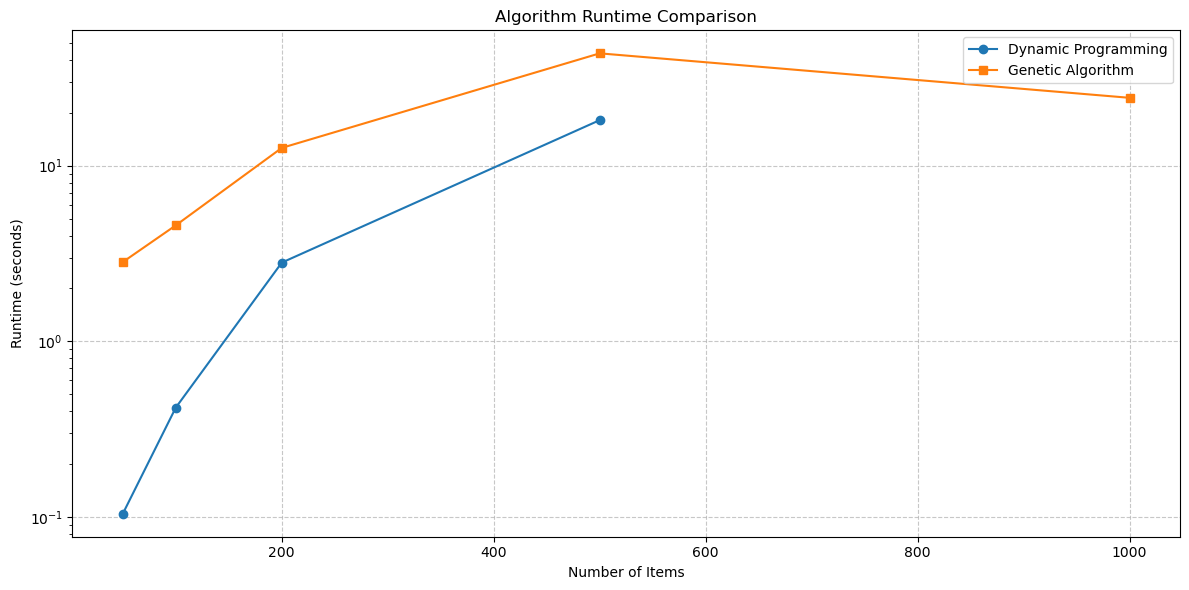

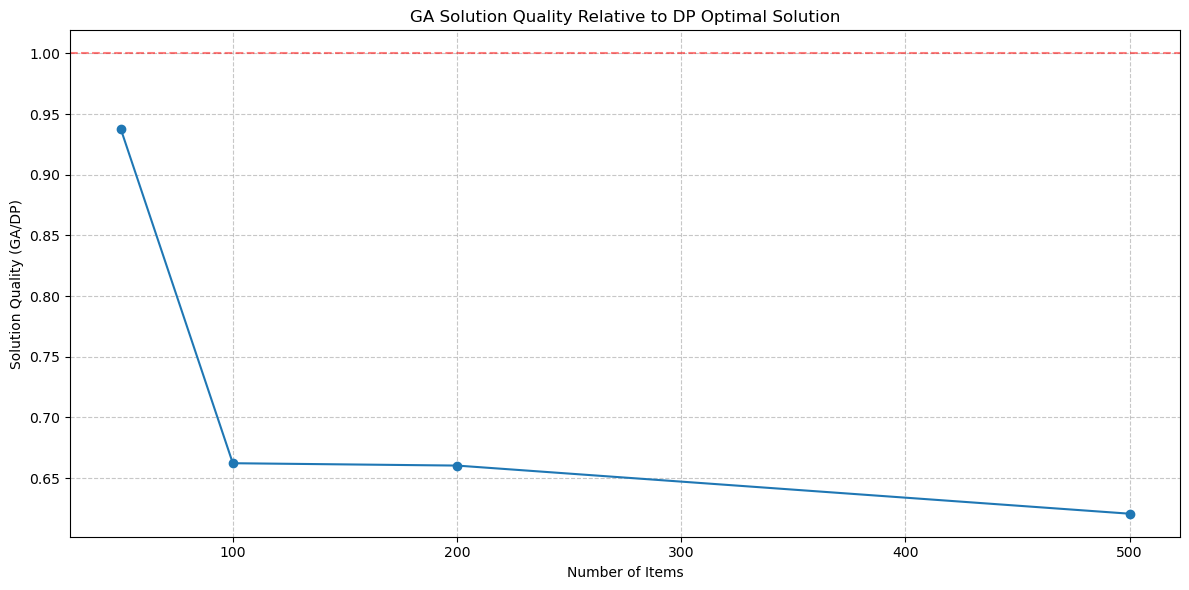

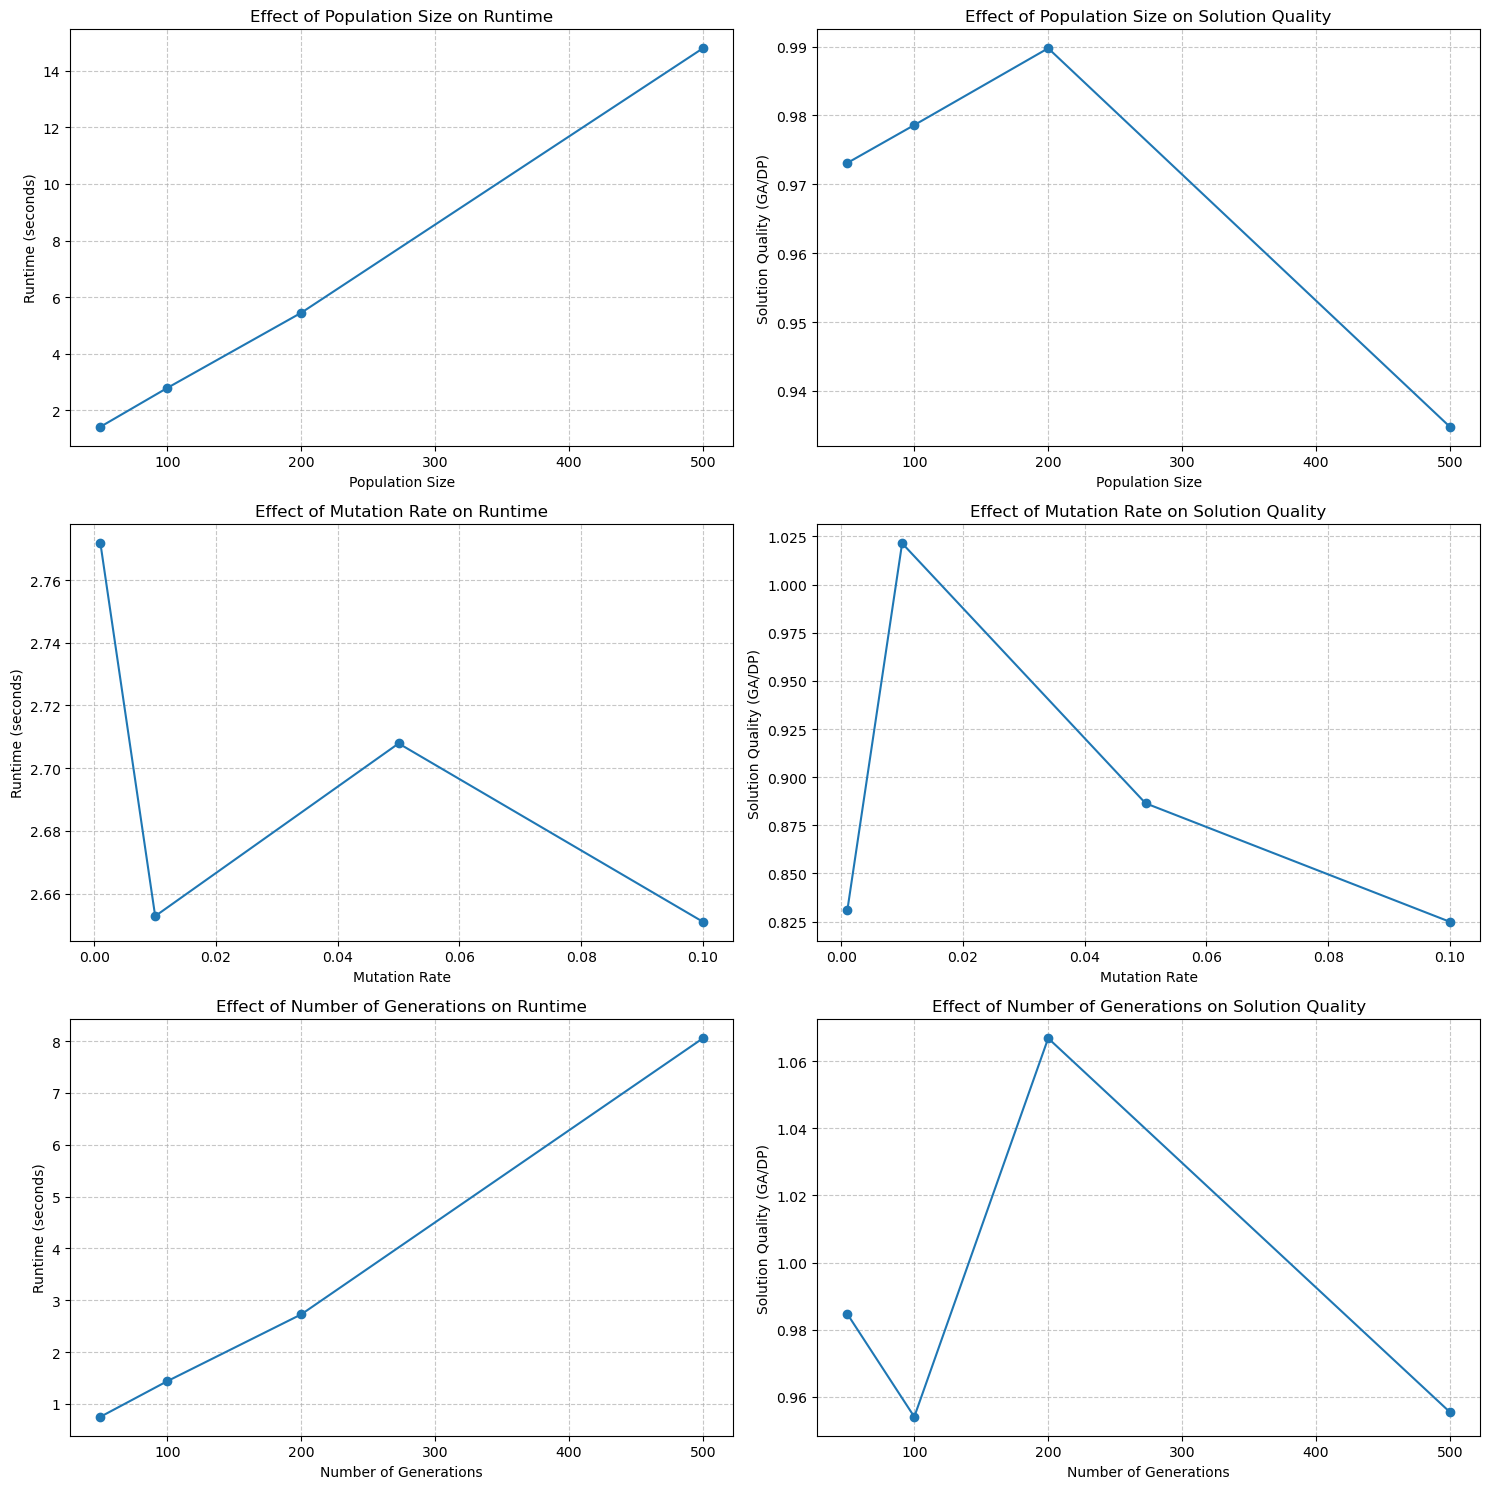

In [22]:
# Cell 11: Example of loading results and visualizing
# This cell would be used after results have been generated

#Load results
comparison_results = pd.read_csv('results/comparison_results.csv')
param_results = pd.read_csv('results/parameter_sensitivity.csv')

# Visualize comparison results
plot_runtime_comparison(comparison_results)
plot_solution_quality(comparison_results)

# Visualize parameter sensitivity
plot_parameter_sensitivity(param_results)


In [23]:
def run_single_comparison(n_items=100, capacity_factor=0.5):
    """Run a single comparison for demonstration purposes"""
    print(f"Running comparison for n_items={n_items}, capacity_factor={capacity_factor}")
    
    # Generate instance
    instance = generate_knapsack_instance(n_items, capacity_factor=capacity_factor)
    weights = instance['weights']
    values = instance['values']
    capacity = instance['capacity']
    
    print(f"Instance generated with capacity: {capacity}")
    
    # Run DP
    start_time = time.time()
    dp_value, dp_selected = solve_knapsack_dp(weights, values, capacity)
    dp_runtime = time.time() - start_time
    
    # Count selected items in DP solution
    dp_selected_count = sum(dp_selected)
    dp_total_weight = sum(weights[i] for i in range(n_items) if dp_selected[i] == 1)
    
    print(f"DP Solution - Value: {dp_value}, Items: {dp_selected_count}, Weight: {dp_total_weight}/{capacity}")
    print(f"DP Runtime: {dp_runtime:.6f} seconds")
    
    # Run GA with different parameters
    ga_params = [
        {'population_size': 50, 'num_generations': 100, 'mutation_rate': 0.01},
        {'population_size': 100, 'num_generations': 200, 'mutation_rate': 0.01},
        {'population_size': 200, 'num_generations': 200, 'mutation_rate': 0.05}
    ]
    
    for params in ga_params:
        start_time = time.time()
        ga_value, ga_selected = solve_knapsack_ga(
            weights, values, capacity,
            population_size=params['population_size'],
            num_generations=params['num_generations'],
            mutation_rate=params['mutation_rate']
        )
        ga_runtime = time.time() - start_time
        
        # Count selected items in GA solution
        ga_selected_count = sum(ga_selected)
        ga_total_weight = sum(weights[i] for i in range(n_items) if ga_selected[i] == 1)
        
        print(f"\nGA Solution with {params}")
        print(f"Value: {ga_value}, Items: {ga_selected_count}, Weight: {ga_total_weight}/{capacity}")
        print(f"GA Runtime: {ga_runtime:.6f} seconds")
        print(f"Solution quality (GA/DP): {ga_value/dp_value:.4f}")

# Run a single comparison when this cell is executed
# run_single_comparison(100, 0.5)